In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
import os
os.getcwd()


'/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody/ipynb'

In [3]:
os.chdir("/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody")
os.getcwd()

'/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody'

In [4]:
# 2. Load and pivot tidy_524
df = pd.read_csv("data/tidy_524.csv")


In [5]:

# 3. Pivot: Accession x Property → Value
df_pivot = df.pivot(index="Accession", columns="Property", values="Value")


In [6]:

# 4. Drop rows with any NA (simple approach for now)
df_clean = df_pivot.dropna()


In [7]:

# 5. Scale features (z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean.values)


In [8]:

# 6. Train/Test split
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)


In [9]:

# 7. Build a simple dense autoencoder (easier than conv for now due to tabular shape)
input_dim = X_train.shape[1]
encoding_dim = 4  # small bottleneck

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(16, activation='relu')(input_layer)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

decoded = layers.Dense(16, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

autoencoder = models.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')



In [10]:
# 8. Train
autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                verbose=1)



Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9468 - val_loss: 1.3476
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9258 - val_loss: 1.3308
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9128 - val_loss: 1.3145
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8984 - val_loss: 1.3000
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8866 - val_loss: 1.2866
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8761 - val_loss: 1.2755
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8652 - val_loss: 1.2666
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8542 - val_loss: 1.2570
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8433 - val_loss: 1.2477
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8317 - val_loss: 1.2376
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8177 - val_loss: 1.2264
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8046 - val_loss: 1.2128
E

In [11]:
# 9. Evaluate
X_test_pred = autoencoder.predict(X_test)
mse = mean_squared_error(X_test, X_test_pred)
print(f"Reconstruction MSE: {mse:.6f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Reconstruction MSE: 0.677547


OK lets reshape our data in an image like manner antibody x patient


In [12]:
import pandas as pd

# Load tidy file
df = pd.read_csv("data/tidy_524.csv")

# Only keep relevant columns
df = df[["Accession", "Property", "Value"]]

# Pivot to get patients × antibodies matrix
df_wide = df.pivot_table(index="Accession", columns="Property", values="Value")

# Fill missing values with 0 or other strategy
df_wide = df_wide.fillna(0)

# Check shape
print(df_wide.shape)


(75, 4)


In [13]:
import numpy as np

X = df_wide.values

# Example: reshape to (n_samples, height, width, channels)
# Let's treat this as a 2x2 image (if 4 antibodies)
X_reshaped = X.reshape((X.shape[0], 2, 2, 1))  # height=2, width=2, channels=1


In [14]:
from tensorflow.keras import layers, models

input_shape = X_reshaped.shape[1:]  # e.g., (2, 2, 1)
input_layer = layers.Input(shape=input_shape)

# Encoder
x = layers.Conv2D(8, (2, 2), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((1, 1), padding='same')(x)
encoded = layers.Conv2D(4, (1, 1), activation='relu', padding='same')(x)

# Decoder
x = layers.Conv2D(4, (1, 1), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((1, 1))(x)
decoded = layers.Conv2D(1, (2, 2), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2, 2, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 2, 2, 8)        │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 2, 2, 4)        │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 4)        │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 2, 2, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 1)        │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113 (452.00 B)

 Trainable params: 113 (452.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
autoencoder.fit(X_reshaped, X_reshaped, epochs=50, batch_size=8, shuffle=True)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 94616.3047   
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 94560.5469
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 94522.0000
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 94506.3750
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 94475.8281
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 94443.1953
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 94438.0859
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 94434.4531
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 94430.7266
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 94426.6719
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 94422.6875
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 94418.6484
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 94414.4766
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 94410.2656


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


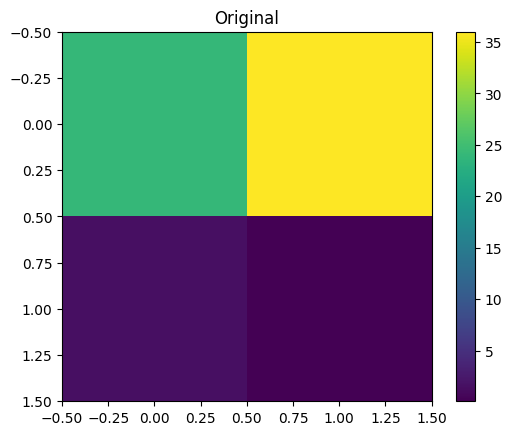

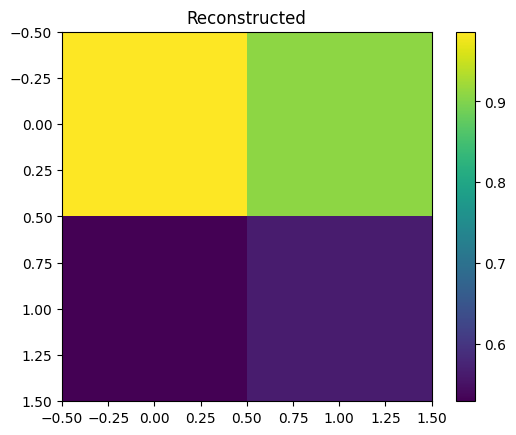

In [17]:
# Reconstruct
reconstructed = autoencoder.predict(X_reshaped)

# Visualize original and reconstructed input
import matplotlib.pyplot as plt

plt.imshow(X_reshaped[0].squeeze(), cmap='viridis')
plt.title("Original")
plt.colorbar()
plt.show()

plt.imshow(reconstructed[0].squeeze(), cmap='viridis')
plt.title("Reconstructed")
plt.colorbar()
plt.show()
